In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl



plt.style.use('https://raw.githubusercontent.com/LinusHats/Scientific_stylesheet/main/style.mplstyle')
def set_size(width_pt=448, fraction=1, subplots=(1, 1)):
    """
    set figuredimensions for nice fit in LaTex
        Params
        ------
        width_pt : float, (optional set for BA_SS)
                Document width in pt \showthe\textwidth
        fraction : float, optional
                Fraction of the width the figure should ocupy
        subplots : array-like, optional
                The number of rows and columns of subplots
        Returns
        -------
        fig_dim : tuple
                Dimenstions of the figure in inches
    """
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1/72.27
    golden_ratio = (5**.5 -1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


color_list = ['#0076C2', '#EC6841', '#6CC24A', '#00B8C8' ,'#E03C31', '#009B77', '#0C2340']
marker_list = ['o', 's', '^', 'v', '<', '>', 'd']
linestyle_list = ['-', '--', '-.', ':', '-', '--', '-.']
style_cycler = plt.cycler(color=color_list, marker=marker_list, linestyle=linestyle_list)
plt.rcParams['axes.prop_cycle'] = style_cycler

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from dataset.dataset import DepictionDataset
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm, trange
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import pandas as pd
from torch.utils.data import random_split, DataLoader
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
import torchvision
import torch.nn as nn

device = torch.device('cpu')
try:
    import torch_directml
    device = torch_directml.device()
    device = torch.device('cpu')
except:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}") 






class ResidualBlock(nn.Module):
    def __init__ (self,  in_channels,  out_channels, dropout_p=0.5 ,stride=1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(p=dropout_p),
            nn.ReLU(inplace=True)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(p=dropout_p),
            )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
        
        
class ResNet(nn.Module):
    def  __init__(self, block, layers, dropout_p, num_classes=8):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.dropout_p = dropout_p
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64 , layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, self.dropout_p, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x






# resnet tested on padded dataset
model_path        = r"/Users/lukaspodolski/sciebo/M3/TU_Delft/kaggle/ResNet_Augmentation_20230918_19-04-07.pth"
dataset_base_path = r"/Users/lukaspodolski/Documents/GitHub/DATASET/paddedWithSpace"
batch_size=256

model = torch.load(model_path, map_location=torch.device('cpu'))

whole_data = DepictionDataset(annotations_file=f"{dataset_base_path}/paddedWithSpaceLabels.csv",
                            img_dir=f"{dataset_base_path}/trainSet", 
                            img_size=(224, 224))

whole_data.set_mean((0.7826,)) 
whole_data.set_std((0.2941,))

train_split = 0.8
test_split = 1-train_split


# make the test data from the dataset
train_data, test_data = random_split(dataset=whole_data,
                                     lengths=[int(len(whole_data)*train_split), int(len(whole_data)*test_split)+1],
                                     generator=torch.Generator().manual_seed(442))

test_dataloader  = DataLoader(test_data, batch_size=batch_size)



# model.eval()
print(f"test_data size: {len(test_data)}")
device = torch.device('mps')
model = model.to(device)
# print(device)

[INFO] Using device: cpu
test_data size: 6643


In [3]:
y_true = []
y_predctions = []
with torch.no_grad():
    correct = total = 0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)       
        output = model(images)
        _, prediction = torch.max(output.data, 1)
        # prediction = prediction.to('cpu')
        y_true.extend(labels.tolist())
        y_predctions.extend(output.tolist())
        total += labels.size(0)
        correct += (prediction == labels).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total}%")
y_predictions = y_predctions

  0%|          | 0/26 [00:00<?, ?it/s]

Accuracy of the model on the test images: 70.19418937227157%


In [4]:
y_pred = [i.index(max(i)) for i in y_predctions]

In [5]:
def transform_tensor_back(image_tensor: torch.Tensor, label: int) -> torch.Tensor:
    """Transforms a tensor based on a prediction. Transform "back" to the "original" image (label=0)"""
    flip = False if label < 4 else True
    if label == 0 or label == 4:
        angle = False
    elif label == 1 or label == 5:
        angle = 270
    elif label == 2 or label == 6:
        angle = 180
    elif label == 3 or label == 7:
        angle = 90
    image_tensor = torchvision.transforms.functional.rotate(image_tensor, angle) if angle is not False else image_tensor
    image_tensor = torchvision.transforms.functional.vflip(image_tensor) if flip is not False else image_tensor
    return image_tensor
def transform_tensor_forward(image_tensor: torch.Tensor, prediction: int) -> torch.Tensor:
    """Transforms a tensor based on a prediction. Transform "back" to the "original" image (label=0)"""
    flip = False if prediction < 4 else True
    if prediction == 0 or prediction == 4:
        angle = False
    elif prediction == 1 or prediction == 5:
        angle = 270
    elif prediction == 2 or prediction == 6:
        angle = 180
    elif prediction == 3 or prediction == 7:
        angle = 90
    image_tensor = torchvision.transforms.functional.vflip(image_tensor) if flip is not False else image_tensor
    image_tensor = torchvision.transforms.functional.rotate(image_tensor, angle) if angle is not False else image_tensor
    return image_tensor

def get_ambiguity_score(image, return_stats: False) -> float:
    if isinstance(image, np.ndarray):
        image = cv2.resize(image, (224, 224))
        image = image.astype("float32") / 255.0
        image = np.transpose(image, (2, 0,  1))
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
    image = image[0]
    image = image.unsqueeze(0)
    embedding1 = model(image)
    prediction = torch.argmax(embedding1, dim=1)
    
    reoriented_image = transform_tensor_back(image, prediction)
    
    embedding2 = model(reoriented_image)
    
    embedding1, embedding2 = embedding1.detach().numpy(), embedding2.detach().numpy()
    similarity = cosine_similarity(embedding1, embedding2)
    if return_stats: return similarity[0][0], (embedding1,  embedding2), reoriented_image
    else: return similarity[0][0]
    
def compare_answer_with_original(image, correct_label):
    if isinstance(image, np.ndarray):
        image = cv2.resize(image, (224, 224))
        image = image.astype("float32") / 255.0
        image = np.transpose(image, (2, 0,  1))
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
    image = image[0]
    image = image.unsqueeze(0)
    # rotate image to original orientation according to label
    original_orientation = transform_tensor_back(image, correct_label)
    original_embedding = model(original_orientation)
    prediction = torch.argmax(original_embedding, dim=1)
    
    # rotate image to predicted orientation
    predicted_orientation = transform_tensor_forward(original_orientation, prediction)
    predicted_embedding = model(predicted_orientation)
    
    original_embedding, predicted_embedding = original_embedding.detach().numpy(), predicted_embedding.detach().numpy()
    similarity = cosine_similarity(original_embedding, predicted_embedding)
    return similarity[0][0], (original_embedding, predicted_embedding), (image, predicted_orientation)
    
    

In [6]:
def get_embedding(image):
    image = image.unsqueeze(0)
    embedding = model(image)
    return embedding

def get_prediction_from_embedding(embedding):
    prediction = torch.argmax(embedding, dim=1)
    return prediction

def rotate_to_corr_orientation(image, ground_truth_label):
    rotated_back = torchvision.transforms.functional.rotate(image, int(90*(ground_truth_label%4))) # 0: -0°, 1: -90°, 2: -180°, 3: -270° ...
    flipped_back = torchvision.transforms.functional.hflip(rotated_back) if ground_truth_label > 3 else rotated_back
    return flipped_back

def rotate_to_pred_orientation(image, prediction):
    flipped = torchvision.transforms.functional.hflip(image) if prediction > 3 else image
    rotated = torchvision.transforms.functional.rotate(flipped, int(-90*(prediction%4))) # 0: 0°, 1: 90°, 2: 180°, 3: 270° ...
    return rotated

def compare_embeddings(embedding1, embedding2):
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

def inference_evaluation(testdata, index):
    input_image, true_label = testdata[index]
    input_image = input_image.to(device)
    original_embedding = model(input_image.unsqueeze(0))
    prediction = get_prediction_from_embedding(original_embedding)
    correct_oriented_image = rotate_to_corr_orientation(input_image, true_label)
    rotated_image = rotate_to_pred_orientation(correct_oriented_image, prediction)
    rotated_embedding = model(rotated_image.unsqueeze(0))    
    original_embedding, rotated_embedding = original_embedding.detach().cpu().numpy(), rotated_embedding.detach().cpu().numpy()
    similarity = compare_embeddings(original_embedding, rotated_embedding)

    return similarity, original_embedding[0], rotated_embedding[0], input_image.cpu().numpy()[0,:,:], rotated_image.cpu().numpy()[0,:,:], true_label, int(prediction)

In [7]:
not_true = []
wrongly_predicted = []
for i in trange(len(y_pred)):
    if y_pred[i] != y_true[i]:
        similarity, original_embedding, rotated_embedding, input_image, rotated_image, true_label, prediction = inference_evaluation(test_data, i)
        eval_obj = {"original_index": i,
                    "similarity": similarity,
                    "original_embedding": original_embedding, 
                    "rotated_embedding": rotated_embedding, 
                    "input_image": input_image, 
                    "rotated_image": rotated_image,
                    "true_label": true_label,
                    "prediction": prediction}
        not_true.append(eval_obj)

  0%|          | 0/6643 [00:00<?, ?it/s]

In [8]:
k = eval_obj
k["similarity"]

0.9676547

In [9]:
y_pred_corrected = y_pred.copy()

similarity_threshold = 0.95 # i'd do 97% here maybe?
true_but_ambiguous = [i for i in not_true if i["similarity"] >= similarity_threshold]
for j in tqdm(true_but_ambiguous):
    index = j["original_index"]
    y_pred_corrected[index] = y_true[index]

  0%|          | 0/1022 [00:00<?, ?it/s]

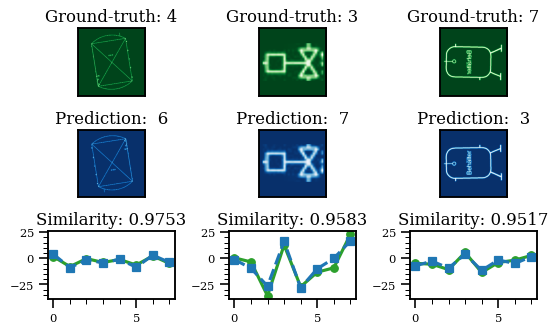

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=set_size(fraction=1, subplots=(3,3)))
for i in range(3):
    j = i+70
    similar_object = true_but_ambiguous[j]
    ax[0][i].imshow(similar_object["input_image"], cmap="Greens")
    ax[1][i].imshow(similar_object["rotated_image"], cmap="Blues")
    # embedding0_mean = np.mean(embeddings[0][0])
    # embedding1_mean = np.mean(embeddings[1][0])
    # ax[2][i].axhline(y=embedding0_mean, color="tab:green", linestyle="--")
    # ax[2][i].axhline(y=embedding1_mean, color="tab:blue", linestyle="--")
    ax[2][i].plot(similar_object["original_embedding"], label="original", color="tab:green")
    ax[2][i].plot(similar_object["rotated_embedding"], label="reoriented", color="tab:blue")
    ax[0][i].set(yticks=[], xticks=[])
    ax[1][i].set(yticks=[], xticks=[])
    ax[0][i].set(title=f"Ground-truth: {similar_object['true_label']}")
    ax[1][i].set(title=f"Prediction:  {similar_object['prediction']}")
    ax[2][i].set(title=f"Similarity: {similar_object['similarity']:.4f}")
for i in ax[2][1:]:
    i.sharey(ax[2][0])
plt.subplots_adjust(wspace=0.1, hspace=0.005)
fig.tight_layout()
fig.savefig("images/similarity.pgf")

In [11]:
print(classification_report(y_true, y_pred))
print(classification_report(y_true, y_pred_corrected))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       848
           1       0.76      0.68      0.72       837
           2       0.78      0.60      0.68       811
           3       0.70      0.72      0.71       869
           4       0.71      0.68      0.69       801
           5       0.80      0.60      0.69       814
           6       0.64      0.77      0.70       828
           7       0.66      0.77      0.71       835

    accuracy                           0.70      6643
   macro avg       0.71      0.70      0.70      6643
weighted avg       0.71      0.70      0.70      6643

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       848
           1       0.90      0.81      0.85       837
           2       0.91      0.82      0.86       811
           3       0.83      0.88      0.85       869
           4       0.86      0.87      0.86       801
           5       0.93 

In [12]:
tu_delft_primary_colors_hex = {
    "Cyan": "#00A6D6",
    "White": "#FFFFFF",
    "Black": "#000000",
}
tu_delft_secondary_colors_hex = {
    "DarkBlue": "#0C2340",
    "Turquoise": "#00B8C8",
    "Blue": "#0076C2",
    "Purple": "#6F1D77",
    "Pink": "#EF60A3",
    "Raspberry": "#A50034",
    "Red": "#E03C31",
    "Orange": "#EC6841",
    "Yellow": "#FFB81C",
    "LightGreen": "#6CC24A",
    "DarkGreen": "#009B77",
}
tu_delft_primary_colors_RGB = {
    "Cyan": (0, 166, 214),
    "White": (255, 255, 255),
    "Black": (0, 0, 0),
}
tu_delft_secondary_colors_RGB = {
    "DarkBlue": (12, 35, 64),
    "Turquoise": (0, 184, 200),
    "Blue": (0, 118, 194),
    "Purple": (111, 29, 119),
    "Pink": (239, 96, 163),
    "Raspberry": (165, 0, 52),
    "Red": (224, 60, 49),
    "Orange": (237, 104, 66),
    "Yellow": (255, 184, 28),
    "LightGreen": (108, 194, 74),
    "DarkGreen": (0, 155, 119),
}




In [13]:
conf_matrix = confusion_matrix(y_true, y_pred)
updated_conf_matrix = confusion_matrix(y_true, y_pred_corrected)
print(conf_matrix)
print(updated_conf_matrix)

[[674   2  11   2  76   0  69  14]
 [ 13 570  10  32  38  60   4 110]
 [ 37   4 484   7  68  20 189   2]
 [ 10  11   2 626   2  32  26 160]
 [167   6  31   0 543   3  44   7]
 [ 10 111  26 117  11 491  14  34]
 [ 96   2  53  22  16   1 635   3]
 [ 35  45   2  90  11   6   6 640]]
[[784   2   6   2  23   0  25   6]
 [ 13 675  10  20  28  21   4  66]
 [ 25   4 666   7  27  13  67   2]
 [ 10   6   2 763   2   9  21  56]
 [ 55   5  11   0 695   1  27   7]
 [  8  36  19  75  11 627  13  25]
 [ 47   2  16  14  10   1 737   1]
 [ 25  16   1  35  11   3   6 738]]


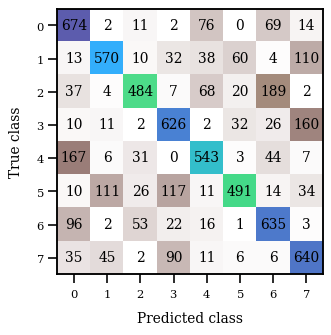

In [14]:
fig,ax = plt.subplots(figsize=set_size(fraction=1, subplots=(1,1)))
ax.imshow(conf_matrix, cmap="terrain_r", alpha=0.8)
ax.set_xticks(range(8), minor=False)
ax.set_yticks(range(8), minor=False)
ax.tick_params(which='minor', length=0)
ax.grid(False)
for i in range(8):
    for j in range(8):
        ax.text(j, i, f'{conf_matrix[i, j]:.0f}', ha="center", va="center", color="black")
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
fig.savefig("images/confusion_matrix_ambiguous.pgf")

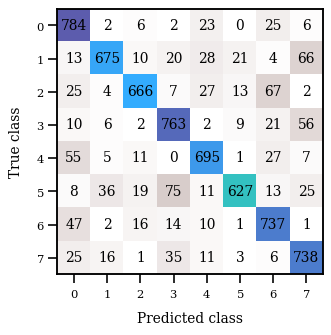

In [15]:
fig,ax = plt.subplots(figsize=set_size(fraction=1, subplots=(1,1)))
ax.imshow(updated_conf_matrix, cmap="terrain_r", alpha=0.8)
ax.set_xticks(range(8), minor=False)
ax.set_yticks(range(8), minor=False)
ax.tick_params(which='minor', length=0)
ax.grid(False)
for i in range(8):
    for j in range(8):
        ax.text(j, i, f'{updated_conf_matrix[i, j]:.0f}', ha="center", va="center", color="black")
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
fig.savefig("images/confusion_matrix_disambiguouation.pgf")